In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import calendar
import time

In [2]:
def plot_image(image, label=''):
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(label)

def plot_images(images, grid_size):
    plt.figure(figsize=(8,8))
    for n, image in enumerate(images[0:grid_size**2]):
        plt.subplot(grid_size, grid_size, n + 1)
        plot_image(image, n)

def plot_dataset(d, n_patches=8):
    plt.figure(figsize=(2*n_patches, 8))
    for n, images in enumerate(d.take(n_patches)):
        input_image = images[0]
        output_image = images[1]
        ih, iw, _ = input_image.get_shape()
        oh, ow, _ = output_image.get_shape()
        
        padding = (ih - oh) // 2
        padded_output = tf.pad(output_image, [[padding, padding], [padding, padding], [0, 0]], "CONSTANT")
        
        plt.subplot(n_patches, 2, 2*n+1)
        plot_image(tf.image.convert_image_dtype(input_image, dtype=tf.uint8), str(n))
        plt.subplot(n_patches, 2, 2*n+2)
        plot_image(tf.image.convert_image_dtype(padded_output, dtype=tf.uint8), str(n))


In [3]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(kernel_size=(9, 9), filters=64, activation='relu'),
  tf.keras.layers.Conv2D(kernel_size=(1, 1), filters=32, activation='relu'),
  tf.keras.layers.Conv2D(kernel_size=(5, 5), filters=3)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [4]:
def resize(image, size, method):
    resized = tf.image.resize(image, size, method)
    if resized.dtype == tf.uint8:
        return resized
    else:
        # deal with https://github.com/tensorflow/tensorflow/issues/10722
        return tf.saturate_cast(resized, tf.uint8)

def prepare_input_image(original_image, input_h, input_w, scale):
    degraded_image = resize(original_image, size=[input_h // scale, input_w // scale], method=tf.image.ResizeMethod.GAUSSIAN)
    input_image = resize(degraded_image, size=[input_h, input_w], method=tf.image.ResizeMethod.BICUBIC)
    return tf.image.convert_image_dtype(input_image, dtype=tf.float32)

def prepare_output_image(original_image, input_size, output_size):
    if output_size == input_size & output_size == input_size:
        output = original_image
    else:
        new_x = (input_size - output_size) // 2
        new_y = (input_size - output_size) // 2
        output = tf.image.crop_to_bounding_box(original_image, new_y, new_x, output_size, output_size)
    return tf.image.convert_image_dtype(output, dtype=tf.float32)

def prepare_crops(filename, input_size, stride, scale, padding=None):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_bmp(image_string)
    if padding is not None:
        image = tf.pad(image, tf.contsant([[padding, padding], [padding, padding], [0, 0]]), "CONSTANT") 
    crops = tf.image.extract_patches(tf.expand_dims(image, 0), [1, input_size, input_size, 1],
                                           [1, stride, stride, 1], [1, 1, 1, 1], 'VALID')
    return tf.reshape(crops[0], [-1, input_size, input_size, 3])

def parse_function(filename, input_size, output_size, stride, scale):
    crops = prepare_crops(filename, input_size, stride, scale)
    input_dataset = tf.data.Dataset.from_tensors(crops).map(lambda img: prepare_input_image(img, input_size, input_size, scale))
    output_dataset = tf.data.Dataset.from_tensors(crops).map(lambda img: prepare_output_image(img, input_size, output_size))
    result = tf.data.Dataset.zip((input_dataset, output_dataset))
    return result

<_UnbatchDataset shapes: ((32, 32, 3), (20, 20, 3)), types: (tf.float32, tf.float32)>


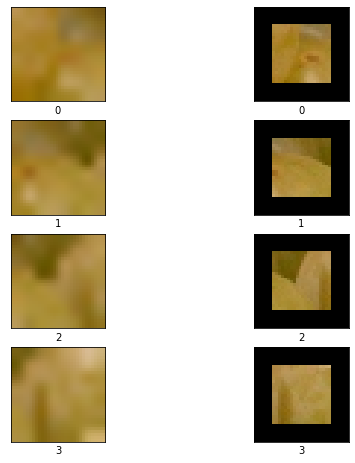

In [5]:
dataset = tf.data.Dataset.list_files("datasets/Train/*.bmp")
dataset = dataset.flat_map(lambda f: parse_function(f, input_size=32, output_size=20, stride=14, scale=4)).unbatch()
print(dataset)
plot_dataset(dataset, n_patches=4)
    
batched_dataset = dataset.shuffle(1000).batch(100).repeat()

In [6]:
run_id=calendar.timegm(time.gmtime())
log_dir=f"logs/{run_id}/"
print(log_dir)
model.fit(batched_dataset, epochs=3000, steps_per_epoch=100, callbacks=[tf.keras.callbacks.TensorBoard(log_dir=log_dir)])

logs/1568893067/
Train for 100 steps
Epoch 1/3000
100/100 [==============================] - 8s 79ms/step - loss: 0.0134 - accuracy: 0.8439
Epoch 2/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0042 - accuracy: 0.9351
Epoch 3/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0045 - accuracy: 0.9137
Epoch 4/3000
100/100 [==============================] - 7s 75ms/step - loss: 0.0036 - accuracy: 0.9536
Epoch 5/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0058 - accuracy: 0.9290
Epoch 6/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0035 - accuracy: 0.9521
Epoch 7/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0035 - accuracy: 0.9483
Epoch 8/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0044 - accuracy: 0.9307
Epoch 9/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0039 - accuracy: 0.9356
Epoch 10/3000
100/100 [=============

100/100 [==============================] - 7s 70ms/step - loss: 0.0039 - accuracy: 0.9483
Epoch 73/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0043 - accuracy: 0.9502
Epoch 74/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0036 - accuracy: 0.9593
Epoch 75/3000
100/100 [==============================] - 8s 83ms/step - loss: 0.0030 - accuracy: 0.9596
Epoch 76/3000
100/100 [==============================] - 8s 78ms/step - loss: 0.0044 - accuracy: 0.9413
Epoch 77/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0030 - accuracy: 0.9641
Epoch 78/3000
100/100 [==============================] - 8s 77ms/step - loss: 0.0042 - accuracy: 0.9409
Epoch 79/3000
100/100 [==============================] - 8s 79ms/step - loss: 0.0040 - accuracy: 0.9410
Epoch 80/3000
100/100 [==============================] - 8s 76ms/step - loss: 0.0033 - accuracy: 0.9621
Epoch 81/3000
100/100 [==============================] - 7s 75ms/step - loss: 

100/100 [==============================] - 7s 71ms/step - loss: 0.0035 - accuracy: 0.9694
Epoch 151/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0037 - accuracy: 0.9458
Epoch 152/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0034 - accuracy: 0.9520
Epoch 153/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0042 - accuracy: 0.9436
Epoch 154/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0038 - accuracy: 0.9341
Epoch 155/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0041 - accuracy: 0.9535
Epoch 156/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0033 - accuracy: 0.9501
Epoch 157/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0033 - accuracy: 0.9532
Epoch 158/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0042 - accuracy: 0.9564
Epoch 159/3000
100/100 [==============================] - 7s 69ms/step

100/100 [==============================] - 7s 69ms/step - loss: 0.0034 - accuracy: 0.9569
Epoch 229/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0035 - accuracy: 0.9666
Epoch 230/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0031 - accuracy: 0.9486
Epoch 231/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0039 - accuracy: 0.9600
Epoch 232/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0037 - accuracy: 0.9333
Epoch 233/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0032 - accuracy: 0.9539
Epoch 234/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0039 - accuracy: 0.9598
Epoch 235/3000
100/100 [==============================] - 7s 69ms/step - loss: 0.0038 - accuracy: 0.9545
Epoch 236/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0034 - accuracy: 0.9441
Epoch 237/3000
100/100 [==============================] - 7s 70ms/step

100/100 [==============================] - 7s 70ms/step - loss: 0.0034 - accuracy: 0.9517
Epoch 307/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0034 - accuracy: 0.9626
Epoch 308/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0034 - accuracy: 0.9553
Epoch 309/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0040 - accuracy: 0.9461
Epoch 310/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0037 - accuracy: 0.9561
Epoch 311/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0028 - accuracy: 0.9580
Epoch 312/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0040 - accuracy: 0.9669
Epoch 313/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0046 - accuracy: 0.9310
Epoch 314/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0030 - accuracy: 0.9566
Epoch 315/3000
100/100 [==============================] - 7s 68ms/step

100/100 [==============================] - 7s 73ms/step - loss: 0.0045 - accuracy: 0.9331
Epoch 498/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0032 - accuracy: 0.9628
Epoch 499/3000
100/100 [==============================] - 8s 78ms/step - loss: 0.0031 - accuracy: 0.9639
Epoch 500/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0046 - accuracy: 0.9364
Epoch 501/3000
100/100 [==============================] - 8s 76ms/step - loss: 0.0038 - accuracy: 0.9482
Epoch 502/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0026 - accuracy: 0.9747
Epoch 503/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0023 - accuracy: 0.9722
Epoch 504/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0048 - accuracy: 0.9325
Epoch 505/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0039 - accuracy: 0.9420
Epoch 506/3000
100/100 [==============================] - 7s 74ms/step

100/100 [==============================] - 7s 74ms/step - loss: 0.0040 - accuracy: 0.9582
Epoch 576/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0034 - accuracy: 0.9658
Epoch 577/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0036 - accuracy: 0.9522
Epoch 578/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0036 - accuracy: 0.9517
Epoch 579/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0038 - accuracy: 0.9464
Epoch 580/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0034 - accuracy: 0.9519
Epoch 581/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0024 - accuracy: 0.9664
Epoch 582/3000
100/100 [==============================] - 8s 78ms/step - loss: 0.0046 - accuracy: 0.9437
Epoch 583/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0039 - accuracy: 0.9461
Epoch 584/3000
100/100 [==============================] - 8s 83ms/step

Epoch 653/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0024 - accuracy: 0.9734
Epoch 654/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0049 - accuracy: 0.9384
Epoch 655/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0029 - accuracy: 0.9442
Epoch 656/3000
100/100 [==============================] - 7s 75ms/step - loss: 0.0038 - accuracy: 0.9594
Epoch 657/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0042 - accuracy: 0.9534
Epoch 658/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0028 - accuracy: 0.9525
Epoch 659/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0044 - accuracy: 0.9558
Epoch 660/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0027 - accuracy: 0.9587
Epoch 661/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0039 - accuracy: 0.9501
Epoch 662/3000
100/100 [==============================]

100/100 [==============================] - 8s 78ms/step - loss: 0.0036 - accuracy: 0.9564
Epoch 732/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0030 - accuracy: 0.9450
Epoch 733/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0039 - accuracy: 0.9649
Epoch 734/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0033 - accuracy: 0.9324
Epoch 735/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0037 - accuracy: 0.9642
Epoch 736/3000
100/100 [==============================] - 8s 75ms/step - loss: 0.0037 - accuracy: 0.9579
Epoch 737/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0040 - accuracy: 0.9522
Epoch 738/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0033 - accuracy: 0.9527
Epoch 739/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0033 - accuracy: 0.9488
Epoch 740/3000
100/100 [==============================] - 7s 73ms/step

100/100 [==============================] - 7s 71ms/step - loss: 0.0033 - accuracy: 0.9505
Epoch 810/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0037 - accuracy: 0.9594
Epoch 811/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0043 - accuracy: 0.9631
Epoch 812/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0033 - accuracy: 0.9420
Epoch 813/3000
100/100 [==============================] - 7s 75ms/step - loss: 0.0030 - accuracy: 0.9661
Epoch 814/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0035 - accuracy: 0.9487
Epoch 815/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0036 - accuracy: 0.9398
Epoch 816/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0035 - accuracy: 0.9709
Epoch 817/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0036 - accuracy: 0.9584
Epoch 818/3000
100/100 [==============================] - 7s 72ms/step

100/100 [==============================] - 9s 90ms/step - loss: 0.0037 - accuracy: 0.9602
Epoch 888/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0041 - accuracy: 0.9580
Epoch 889/3000
100/100 [==============================] - 9s 95ms/step - loss: 0.0034 - accuracy: 0.9428
Epoch 890/3000
100/100 [==============================] - 9s 92ms/step - loss: 0.0032 - accuracy: 0.9556
Epoch 891/3000
100/100 [==============================] - 9s 91ms/step - loss: 0.0038 - accuracy: 0.9578
Epoch 892/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0033 - accuracy: 0.9648
Epoch 893/3000
100/100 [==============================] - 9s 91ms/step - loss: 0.0034 - accuracy: 0.9433
Epoch 894/3000
100/100 [==============================] - 10s 98ms/step - loss: 0.0039 - accuracy: 0.9632
Epoch 895/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0031 - accuracy: 0.9606
Epoch 896/3000
100/100 [==============================] - 9s 93ms/ste

100/100 [==============================] - 7s 71ms/step - loss: 0.0037 - accuracy: 0.9292
Epoch 965/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0029 - accuracy: 0.9576
Epoch 966/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0032 - accuracy: 0.9709
Epoch 967/3000
100/100 [==============================] - 7s 75ms/step - loss: 0.0031 - accuracy: 0.9572
Epoch 968/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0043 - accuracy: 0.9556
Epoch 969/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0031 - accuracy: 0.9515
Epoch 970/3000
100/100 [==============================] - 8s 75ms/step - loss: 0.0039 - accuracy: 0.9611
Epoch 971/3000
100/100 [==============================] - 8s 77ms/step - loss: 0.0038 - accuracy: 0.9468
Epoch 972/3000
100/100 [==============================] - 8s 76ms/step - loss: 0.0032 - accuracy: 0.9732
Epoch 973/3000
100/100 [==============================] - 8s 84ms/step

100/100 [==============================] - 8s 78ms/step - loss: 0.0031 - accuracy: 0.9697
Epoch 1042/3000
100/100 [==============================] - 8s 83ms/step - loss: 0.0035 - accuracy: 0.9598
Epoch 1043/3000
100/100 [==============================] - 8s 80ms/step - loss: 0.0045 - accuracy: 0.9458
Epoch 1044/3000
100/100 [==============================] - 8s 75ms/step - loss: 0.0029 - accuracy: 0.9635
Epoch 1045/3000
100/100 [==============================] - 8s 80ms/step - loss: 0.0036 - accuracy: 0.9607
Epoch 1046/3000
100/100 [==============================] - 8s 76ms/step - loss: 0.0034 - accuracy: 0.9531
Epoch 1047/3000
100/100 [==============================] - 8s 76ms/step - loss: 0.0032 - accuracy: 0.9506
Epoch 1048/3000
100/100 [==============================] - 8s 79ms/step - loss: 0.0037 - accuracy: 0.9627
Epoch 1049/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0033 - accuracy: 0.9493
Epoch 1050/3000
100/100 [==============================] - 7s 

100/100 [==============================] - 8s 75ms/step - loss: 0.0033 - accuracy: 0.9622
Epoch 1119/3000
100/100 [==============================] - 8s 75ms/step - loss: 0.0036 - accuracy: 0.9470
Epoch 1120/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0042 - accuracy: 0.9439
Epoch 1121/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0032 - accuracy: 0.9672
Epoch 1122/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0033 - accuracy: 0.9595
Epoch 1123/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0034 - accuracy: 0.9524
Epoch 1124/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0038 - accuracy: 0.9645
Epoch 1125/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0036 - accuracy: 0.9471
Epoch 1126/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0031 - accuracy: 0.9642
Epoch 1127/3000
100/100 [==============================] - 7s 

100/100 [==============================] - 9s 94ms/step - loss: 0.0040 - accuracy: 0.9588
Epoch 1195/3000
100/100 [==============================] - 11s 110ms/step - loss: 0.0032 - accuracy: 0.9514
Epoch 1196/3000
100/100 [==============================] - 9s 93ms/step - loss: 0.0030 - accuracy: 0.9507
Epoch 1197/3000
100/100 [==============================] - 10s 103ms/step - loss: 0.0035 - accuracy: 0.9669
Epoch 1198/3000
100/100 [==============================] - 10s 102ms/step - loss: 0.0047 - accuracy: 0.9511
Epoch 1199/3000
100/100 [==============================] - 9s 93ms/step - loss: 0.0027 - accuracy: 0.9569
Epoch 1200/3000
100/100 [==============================] - 10s 102ms/step - loss: 0.0036 - accuracy: 0.9521
Epoch 1201/3000
100/100 [==============================] - 10s 101ms/step - loss: 0.0034 - accuracy: 0.9578
Epoch 1202/3000
100/100 [==============================] - 10s 100ms/step - loss: 0.0037 - accuracy: 0.9598
Epoch 1203/3000
100/100 [=========================

100/100 [==============================] - 7s 72ms/step - loss: 0.0033 - accuracy: 0.9510
Epoch 1272/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0033 - accuracy: 0.9553
Epoch 1273/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0038 - accuracy: 0.9581
Epoch 1274/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0027 - accuracy: 0.9549
Epoch 1275/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0038 - accuracy: 0.9570
Epoch 1276/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0034 - accuracy: 0.9638
Epoch 1277/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0036 - accuracy: 0.9642
Epoch 1278/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0038 - accuracy: 0.9366
Epoch 1279/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0030 - accuracy: 0.9676
Epoch 1280/3000
100/100 [==============================] - 7s 

100/100 [==============================] - 8s 83ms/step - loss: 0.0033 - accuracy: 0.9456
Epoch 1349/3000
100/100 [==============================] - 8s 81ms/step - loss: 0.0037 - accuracy: 0.9632
Epoch 1350/3000
100/100 [==============================] - 8s 82ms/step - loss: 0.0039 - accuracy: 0.9486
Epoch 1351/3000
100/100 [==============================] - 9s 95ms/step - loss: 0.0031 - accuracy: 0.9635
Epoch 1352/3000
100/100 [==============================] - 8s 83ms/step - loss: 0.0043 - accuracy: 0.9513
Epoch 1353/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0028 - accuracy: 0.9669
Epoch 1354/3000
100/100 [==============================] - 8s 82ms/step - loss: 0.0030 - accuracy: 0.9494
Epoch 1355/3000
100/100 [==============================] - 8s 81ms/step - loss: 0.0041 - accuracy: 0.9442
Epoch 1356/3000
100/100 [==============================] - 8s 79ms/step - loss: 0.0030 - accuracy: 0.9682
Epoch 1357/3000
100/100 [==============================] - 8s 

100/100 [==============================] - 7s 74ms/step - loss: 0.0027 - accuracy: 0.9541
Epoch 1426/3000
100/100 [==============================] - 8s 75ms/step - loss: 0.0042 - accuracy: 0.9406
Epoch 1427/3000
100/100 [==============================] - 7s 75ms/step - loss: 0.0029 - accuracy: 0.9656
Epoch 1428/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0035 - accuracy: 0.9527
Epoch 1429/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0033 - accuracy: 0.9626
Epoch 1430/3000
100/100 [==============================] - 8s 82ms/step - loss: 0.0030 - accuracy: 0.9488
Epoch 1431/3000
100/100 [==============================] - 8s 78ms/step - loss: 0.0037 - accuracy: 0.9667
Epoch 1432/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0042 - accuracy: 0.9479
Epoch 1433/3000
100/100 [==============================] - 7s 75ms/step - loss: 0.0030 - accuracy: 0.9680
Epoch 1434/3000
100/100 [==============================] - 8s 

100/100 [==============================] - 7s 72ms/step - loss: 0.0035 - accuracy: 0.9638
Epoch 1503/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0030 - accuracy: 0.9490
Epoch 1504/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0035 - accuracy: 0.9526
Epoch 1505/3000
100/100 [==============================] - 8s 75ms/step - loss: 0.0034 - accuracy: 0.9569
Epoch 1506/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0028 - accuracy: 0.9627
Epoch 1507/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0040 - accuracy: 0.9407
Epoch 1508/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0038 - accuracy: 0.9651
Epoch 1509/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0034 - accuracy: 0.9672
Epoch 1510/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0032 - accuracy: 0.9469
Epoch 1511/3000
100/100 [==============================] - 8s 

100/100 [==============================] - 8s 78ms/step - loss: 0.0041 - accuracy: 0.9594
Epoch 1580/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0040 - accuracy: 0.9468
Epoch 1581/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0028 - accuracy: 0.9685
Epoch 1582/3000
100/100 [==============================] - 9s 88ms/step - loss: 0.0039 - accuracy: 0.9610
Epoch 1583/3000
100/100 [==============================] - 8s 76ms/step - loss: 0.0033 - accuracy: 0.9673
Epoch 1584/3000
100/100 [==============================] - 8s 80ms/step - loss: 0.0030 - accuracy: 0.9541
Epoch 1585/3000
100/100 [==============================] - 9s 85ms/step - loss: 0.0037 - accuracy: 0.9483
Epoch 1586/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0028 - accuracy: 0.9561
Epoch 1587/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0037 - accuracy: 0.9578
Epoch 1588/3000
100/100 [==============================] - 7s 

100/100 [==============================] - 9s 90ms/step - loss: 0.0043 - accuracy: 0.9421
Epoch 1657/3000
100/100 [==============================] - 8s 83ms/step - loss: 0.0027 - accuracy: 0.9689
Epoch 1658/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0039 - accuracy: 0.9556
Epoch 1659/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0029 - accuracy: 0.9557
Epoch 1660/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0043 - accuracy: 0.9430
Epoch 1661/3000
100/100 [==============================] - 10s 97ms/step - loss: 0.0031 - accuracy: 0.9601
Epoch 1662/3000
100/100 [==============================] - 9s 93ms/step - loss: 0.0030 - accuracy: 0.9594
Epoch 1663/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0030 - accuracy: 0.9602
Epoch 1664/3000
100/100 [==============================] - 9s 94ms/step - loss: 0.0040 - accuracy: 0.9583
Epoch 1665/3000
100/100 [==============================] - 9s

100/100 [==============================] - 7s 70ms/step - loss: 0.0027 - accuracy: 0.9543
Epoch 1734/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0028 - accuracy: 0.9507
Epoch 1735/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0042 - accuracy: 0.9588
Epoch 1736/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0030 - accuracy: 0.9517
Epoch 1737/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0043 - accuracy: 0.9626
Epoch 1738/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0036 - accuracy: 0.9567
Epoch 1739/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0034 - accuracy: 0.9435
Epoch 1740/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0035 - accuracy: 0.9506
Epoch 1741/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0032 - accuracy: 0.9714
Epoch 1742/3000
100/100 [==============================] - 7s 

100/100 [==============================] - 7s 71ms/step - loss: 0.0034 - accuracy: 0.9602
Epoch 1811/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0033 - accuracy: 0.9546
Epoch 1812/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0035 - accuracy: 0.9449
Epoch 1813/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0035 - accuracy: 0.9573
Epoch 1814/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0036 - accuracy: 0.9611
Epoch 1815/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0033 - accuracy: 0.9523
Epoch 1816/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0040 - accuracy: 0.9647
Epoch 1817/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0035 - accuracy: 0.9533
Epoch 1818/3000
100/100 [==============================] - 7s 69ms/step - loss: 0.0025 - accuracy: 0.9458
Epoch 1819/3000
100/100 [==============================] - 7s 

100/100 [==============================] - 7s 68ms/step - loss: 0.0036 - accuracy: 0.9545
Epoch 1888/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0041 - accuracy: 0.9535
Epoch 1889/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0029 - accuracy: 0.9699
Epoch 1890/3000
100/100 [==============================] - 7s 69ms/step - loss: 0.0036 - accuracy: 0.9615
Epoch 1891/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0035 - accuracy: 0.9464
Epoch 1892/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0036 - accuracy: 0.9584
Epoch 1893/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0033 - accuracy: 0.9545
Epoch 1894/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0033 - accuracy: 0.9587
Epoch 1895/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0038 - accuracy: 0.9575
Epoch 1896/3000
100/100 [==============================] - 7s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



100/100 [==============================] - 7s 68ms/step - loss: 0.0033 - accuracy: 0.9581
Epoch 1916/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0037 - accuracy: 0.9597
Epoch 1917/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0033 - accuracy: 0.9591
Epoch 1918/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0034 - accuracy: 0.9438
Epoch 1919/3000
100/100 [==============================] - 7s 69ms/step - loss: 0.0042 - accuracy: 0.9613
Epoch 1920/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0030 - accuracy: 0.9545
Epoch 1921/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0032 - accuracy: 0.9527
Epoch 1922/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0039 - accuracy: 0.9574
Epoch 1923/3000
100/100 [==============================] - 7s 68ms/step - loss: 0.0033 - accuracy: 0.9645
Epoch 1924/3000
100/100 [==============================] - 7s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



100/100 [==============================] - 8s 79ms/step - loss: 0.0041 - accuracy: 0.9616
Epoch 1945/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0026 - accuracy: 0.9492
Epoch 1946/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0037 - accuracy: 0.9418
Epoch 1947/3000
100/100 [==============================] - 7s 75ms/step - loss: 0.0040 - accuracy: 0.9594
Epoch 1948/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0029 - accuracy: 0.9540
Epoch 1949/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0039 - accuracy: 0.9604
Epoch 1950/3000
100/100 [==============================] - 8s 78ms/step - loss: 0.0027 - accuracy: 0.9509
Epoch 1951/3000
100/100 [==============================] - 8s 78ms/step - loss: 0.0038 - accuracy: 0.9593
Epoch 1952/3000
100/100 [==============================] - 8s 84ms/step - loss: 0.0040 - accuracy: 0.9632
Epoch 1953/3000
100/100 [==============================] - 8s 

100/100 [==============================] - 9s 87ms/step - loss: 0.0025 - accuracy: 0.9550
Epoch 2022/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0039 - accuracy: 0.9587
Epoch 2023/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0033 - accuracy: 0.9540
Epoch 2024/3000
100/100 [==============================] - 9s 86ms/step - loss: 0.0040 - accuracy: 0.9673
Epoch 2025/3000
100/100 [==============================] - 8s 85ms/step - loss: 0.0032 - accuracy: 0.9444
Epoch 2026/3000
100/100 [==============================] - 9s 86ms/step - loss: 0.0027 - accuracy: 0.9696
Epoch 2027/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0042 - accuracy: 0.9453
Epoch 2028/3000
100/100 [==============================] - 9s 87ms/step - loss: 0.0046 - accuracy: 0.9528
Epoch 2029/3000
100/100 [==============================] - 9s 90ms/step - loss: 0.0025 - accuracy: 0.9684
Epoch 2030/3000
100/100 [==============================] - 9s 

100/100 [==============================] - 8s 81ms/step - loss: 0.0036 - accuracy: 0.9575
Epoch 2099/3000
100/100 [==============================] - 8s 77ms/step - loss: 0.0034 - accuracy: 0.9498
Epoch 2100/3000
100/100 [==============================] - 8s 75ms/step - loss: 0.0035 - accuracy: 0.9506
Epoch 2101/3000
100/100 [==============================] - 8s 77ms/step - loss: 0.0034 - accuracy: 0.9655
Epoch 2102/3000
100/100 [==============================] - 8s 80ms/step - loss: 0.0040 - accuracy: 0.9643
Epoch 2103/3000
100/100 [==============================] - 8s 82ms/step - loss: 0.0029 - accuracy: 0.9453
Epoch 2104/3000
100/100 [==============================] - 8s 80ms/step - loss: 0.0034 - accuracy: 0.9639
Epoch 2105/3000
100/100 [==============================] - 8s 83ms/step - loss: 0.0032 - accuracy: 0.9520
Epoch 2106/3000
100/100 [==============================] - 9s 86ms/step - loss: 0.0041 - accuracy: 0.9510
Epoch 2107/3000
100/100 [==============================] - 9s 

100/100 [==============================] - 7s 70ms/step - loss: 0.0037 - accuracy: 0.9460
Epoch 2176/3000
100/100 [==============================] - 8s 79ms/step - loss: 0.0035 - accuracy: 0.9614
Epoch 2177/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0039 - accuracy: 0.9597
Epoch 2178/3000
100/100 [==============================] - 8s 83ms/step - loss: 0.0025 - accuracy: 0.9591
Epoch 2179/3000
100/100 [==============================] - 8s 76ms/step - loss: 0.0038 - accuracy: 0.9483
Epoch 2180/3000
100/100 [==============================] - 9s 85ms/step - loss: 0.0038 - accuracy: 0.9551
Epoch 2181/3000
100/100 [==============================] - 8s 79ms/step - loss: 0.0031 - accuracy: 0.9722
Epoch 2182/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0030 - accuracy: 0.9650
Epoch 2183/3000
100/100 [==============================] - 8s 84ms/step - loss: 0.0041 - accuracy: 0.9504
Epoch 2184/3000
100/100 [==============================] - 8s 

100/100 [==============================] - 8s 84ms/step - loss: 0.0042 - accuracy: 0.9520
Epoch 2253/3000
100/100 [==============================] - 9s 89ms/step - loss: 0.0035 - accuracy: 0.9475
Epoch 2254/3000
100/100 [==============================] - 10s 104ms/step - loss: 0.0034 - accuracy: 0.9575
Epoch 2255/3000
100/100 [==============================] - 10s 101ms/step - loss: 0.0035 - accuracy: 0.9602
Epoch 2256/3000
100/100 [==============================] - 10s 100ms/step - loss: 0.0037 - accuracy: 0.9500
Epoch 2257/3000
100/100 [==============================] - 11s 114ms/step - loss: 0.0036 - accuracy: 0.9598
Epoch 2258/3000
100/100 [==============================] - 8s 78ms/step - loss: 0.0035 - accuracy: 0.9439
Epoch 2259/3000
100/100 [==============================] - 8s 79ms/step - loss: 0.0035 - accuracy: 0.9645
Epoch 2260/3000
100/100 [==============================] - 7s 75ms/step - loss: 0.0035 - accuracy: 0.9591
Epoch 2261/3000
100/100 [=============================

100/100 [==============================] - 7s 72ms/step - loss: 0.0031 - accuracy: 0.9646
Epoch 2330/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0040 - accuracy: 0.9498
Epoch 2331/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0027 - accuracy: 0.9639
Epoch 2332/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0038 - accuracy: 0.9684
Epoch 2333/3000
100/100 [==============================] - 8s 76ms/step - loss: 0.0034 - accuracy: 0.9479
Epoch 2334/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0037 - accuracy: 0.9529
Epoch 2335/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0030 - accuracy: 0.9630
Epoch 2336/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0037 - accuracy: 0.9475
Epoch 2337/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0036 - accuracy: 0.9643
Epoch 2338/3000
100/100 [==============================] - 7s 

100/100 [==============================] - 8s 76ms/step - loss: 0.0036 - accuracy: 0.9601
Epoch 2407/3000
100/100 [==============================] - 8s 77ms/step - loss: 0.0033 - accuracy: 0.9563
Epoch 2408/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0034 - accuracy: 0.9711
Epoch 2409/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0033 - accuracy: 0.9461
Epoch 2410/3000
100/100 [==============================] - 8s 79ms/step - loss: 0.0039 - accuracy: 0.9526
Epoch 2411/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0034 - accuracy: 0.9641
Epoch 2412/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0034 - accuracy: 0.9488
Epoch 2413/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0037 - accuracy: 0.9481
Epoch 2414/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0031 - accuracy: 0.9581
Epoch 2415/3000
100/100 [==============================] - 7s 

100/100 [==============================] - 7s 74ms/step - loss: 0.0040 - accuracy: 0.9530
Epoch 2484/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0027 - accuracy: 0.9655
Epoch 2485/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0034 - accuracy: 0.9616
Epoch 2486/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0038 - accuracy: 0.9689
Epoch 2487/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0035 - accuracy: 0.9358
Epoch 2488/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0036 - accuracy: 0.9551
Epoch 2489/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0029 - accuracy: 0.9652
Epoch 2490/3000
100/100 [==============================] - 9s 85ms/step - loss: 0.0031 - accuracy: 0.9669
Epoch 2491/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0043 - accuracy: 0.9505
Epoch 2492/3000
100/100 [==============================] - 7s 

100/100 [==============================] - 7s 71ms/step - loss: 0.0040 - accuracy: 0.9476
Epoch 2561/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0042 - accuracy: 0.9609
Epoch 2562/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0028 - accuracy: 0.9547
Epoch 2563/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0033 - accuracy: 0.9651
Epoch 2564/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0036 - accuracy: 0.9480
Epoch 2565/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0032 - accuracy: 0.9444
Epoch 2566/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0030 - accuracy: 0.9660
Epoch 2567/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0041 - accuracy: 0.9596
Epoch 2568/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0037 - accuracy: 0.9501
Epoch 2569/3000
100/100 [==============================] - 7s 

100/100 [==============================] - 8s 80ms/step - loss: 0.0031 - accuracy: 0.9545
Epoch 2638/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0039 - accuracy: 0.9624
Epoch 2639/3000
100/100 [==============================] - 8s 77ms/step - loss: 0.0045 - accuracy: 0.9495
Epoch 2640/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0026 - accuracy: 0.9650
Epoch 2641/3000
100/100 [==============================] - 8s 75ms/step - loss: 0.0029 - accuracy: 0.9692
Epoch 2642/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0043 - accuracy: 0.9422
Epoch 2643/3000
100/100 [==============================] - 7s 75ms/step - loss: 0.0034 - accuracy: 0.9657
Epoch 2644/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0037 - accuracy: 0.9460
Epoch 2645/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0028 - accuracy: 0.9736
Epoch 2646/3000
100/100 [==============================] - 7s 

100/100 [==============================] - 7s 73ms/step - loss: 0.0033 - accuracy: 0.9688
Epoch 2715/3000
100/100 [==============================] - 8s 75ms/step - loss: 0.0028 - accuracy: 0.9573
Epoch 2716/3000
100/100 [==============================] - 8s 76ms/step - loss: 0.0035 - accuracy: 0.9587
Epoch 2717/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0041 - accuracy: 0.9545
Epoch 2718/3000
100/100 [==============================] - 8s 75ms/step - loss: 0.0038 - accuracy: 0.9484
Epoch 2719/3000
100/100 [==============================] - 7s 75ms/step - loss: 0.0031 - accuracy: 0.9686
Epoch 2720/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0033 - accuracy: 0.9502
Epoch 2721/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0031 - accuracy: 0.9659
Epoch 2722/3000
100/100 [==============================] - 7s 75ms/step - loss: 0.0032 - accuracy: 0.9522
Epoch 2723/3000
100/100 [==============================] - 8s 

100/100 [==============================] - 7s 72ms/step - loss: 0.0034 - accuracy: 0.9598
Epoch 2792/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0037 - accuracy: 0.9543
Epoch 2793/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0029 - accuracy: 0.9597
Epoch 2794/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0037 - accuracy: 0.9599
Epoch 2795/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0035 - accuracy: 0.9640
Epoch 2796/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0043 - accuracy: 0.9419
Epoch 2797/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0027 - accuracy: 0.9701
Epoch 2798/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0036 - accuracy: 0.9594
Epoch 2799/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0031 - accuracy: 0.9513
Epoch 2800/3000
100/100 [==============================] - 7s 

100/100 [==============================] - 7s 70ms/step - loss: 0.0033 - accuracy: 0.9557
Epoch 2869/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0037 - accuracy: 0.9509
Epoch 2870/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0034 - accuracy: 0.9623
Epoch 2871/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0039 - accuracy: 0.9654
Epoch 2872/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0031 - accuracy: 0.9537
Epoch 2873/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0038 - accuracy: 0.9645
Epoch 2874/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0030 - accuracy: 0.9657
Epoch 2875/3000
100/100 [==============================] - 7s 70ms/step - loss: 0.0039 - accuracy: 0.9422
Epoch 2876/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0025 - accuracy: 0.9547
Epoch 2877/3000
100/100 [==============================] - 7s 

100/100 [==============================] - 7s 73ms/step - loss: 0.0037 - accuracy: 0.9646
Epoch 2946/3000
100/100 [==============================] - 7s 71ms/step - loss: 0.0032 - accuracy: 0.9439
Epoch 2947/3000
100/100 [==============================] - 8s 75ms/step - loss: 0.0045 - accuracy: 0.9583
Epoch 2948/3000
100/100 [==============================] - 8s 79ms/step - loss: 0.0024 - accuracy: 0.9608
Epoch 2949/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0035 - accuracy: 0.9690
Epoch 2950/3000
100/100 [==============================] - 8s 76ms/step - loss: 0.0029 - accuracy: 0.9608
Epoch 2951/3000
100/100 [==============================] - 7s 72ms/step - loss: 0.0041 - accuracy: 0.9469
Epoch 2952/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0026 - accuracy: 0.9613
Epoch 2953/3000
100/100 [==============================] - 7s 73ms/step - loss: 0.0038 - accuracy: 0.9563
Epoch 2954/3000
100/100 [==============================] - 8s 

tf.Tensor([37.43782  35.54762  22.351511 35.41258  31.888153 26.840729], shape=(6,), dtype=float32)
tf.Tensor([37.75605  35.68677  22.640318 35.24682  31.804989 28.93274 ], shape=(6,), dtype=float32)


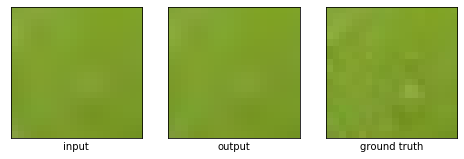

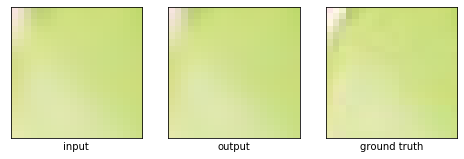

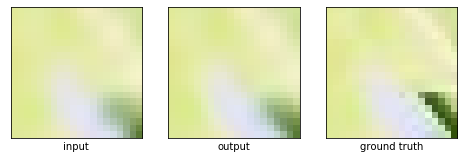

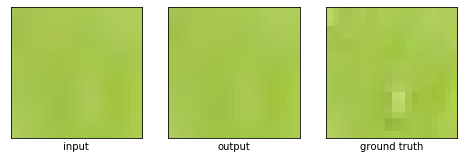

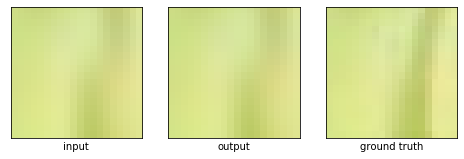

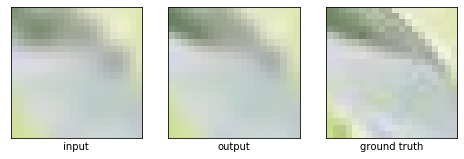

In [41]:
def plot_predictions(d, model, count):
    d_small = d.shuffle(100).take(count)
    
    inputs = []
    ground_truth = []
    identity = lambda x, y: (x, y)
    for i, g in d_small.map(identity):
        inputs.append(i)
        ground_truth.append(g)
    
    inputs = tf.stack(inputs)
    ground_truth = tf.stack(ground_truth)
    outputs = tf.clip_by_value(model.predict(inputs), 0, 1)
    
    _, in_h, in_w, _ = inputs.get_shape()
    _, out_h, out_w, _ = outputs.shape
    new_x = (in_w - out_w) // 2
    new_y = (in_h - out_h) // 2
    inputs = tf.image.crop_to_bounding_box(inputs, new_y, new_x, out_h, out_w)
    
    for i, o, g in zip(inputs, outputs, ground_truth):
        plt.figure(figsize=(8, 8))
        plt.subplot(1, 3, 1)
        plot_image(i, "input")
        plt.subplot(1, 3, 2)
        plot_image(o, "output")
        plt.subplot(1, 3, 3)
        plot_image(g, "ground truth")
        
    print(tf.image.psnr(inputs, ground_truth, max_val=1.0))
    print(tf.image.psnr(outputs, ground_truth, max_val=1.0))
    
plot_predictions(dataset, model, 6)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  15616     
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  2080      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [9]:
import os
model_dir='models'
#os.mkdir(model_dir)
model_path = f"{model_dir}/{run_id}.h5"
model.save(model_path)

,Image Name,PSNR: Input,PSNR: SRCNN
0,baby,30.160,30.359
1,bird,28.285,28.772
2,butterfly,20.716,21.881
3,head,28.525,28.709
4,woman,25.091,25.408


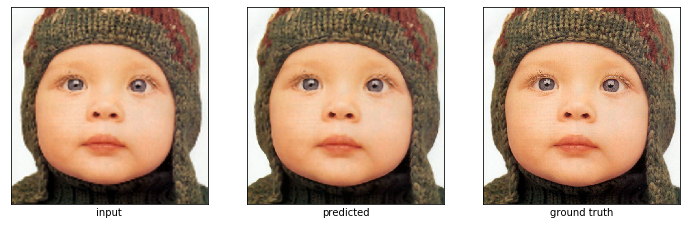

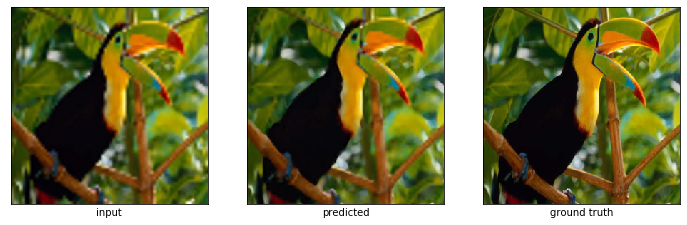

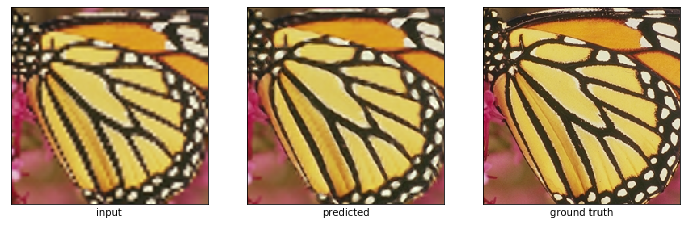

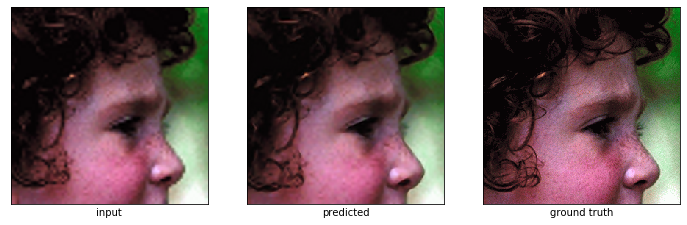

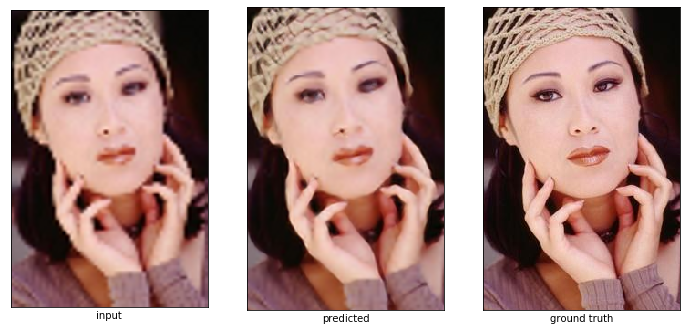

In [40]:
model_dir='models'
model_path = f"{model_dir}/{run_id}.h5"
restored_model = tf.keras.models.load_model(model_path)
input_size = 32
output_size=20

psnr = []

for filename in tf.io.matching_files("datasets/Test/Set5/*.bmp"):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_bmp(image_string, channels=3)
    
    h, w, _ = image.get_shape()
    padding = (input_size - output_size) // 2
    ground_truth = tf.image.crop_to_bounding_box(image, padding, padding, h - 2*padding, w - 2*padding)
    
    image = prepare_input_image(image, h, w, scale=4)
    
    cropped_input = tf.image.crop_to_bounding_box(image, padding, padding, h - 2*padding, w - 2*padding)
    psnr_bicubic = tf.image.psnr(cropped_input, ground_truth, max_val=1.0)
    
    predicted = tf.clip_by_value(restored_model(tf.expand_dims(image, 0))[0], 0, 1)
    psnr_predicted = tf.image.psnr(predicted, ground_truth, max_val=1.0)
    
    saved_filename = filename + ".png"
    tf.io.write_file(saved_filename, tf.image.encode_png(tf.image.convert_image_dtype(predicted, dtype=tf.uint8)))
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plot_image(image, "input")
    
    plt.subplot(1, 3, 2)
    plot_image(predicted, "predicted")
    
    plt.subplot(1, 3, 3)
    plot_image(ground_truth, "ground truth")
    
    short_name = os.path.split(f"{filename}")[1]
    last_index = short_name.find("_")
    
    short_name = short_name[:last_index]
    psnr.append([short_name, f"{psnr_bicubic:.3f}", f"{psnr_predicted:.3f}"])
    

import pandas as pd
pd.DataFrame(psnr, columns=["Image Name", "PSNR: Input", "PSNR: SRCNN"])
